# Predicting Survival on the Titanic

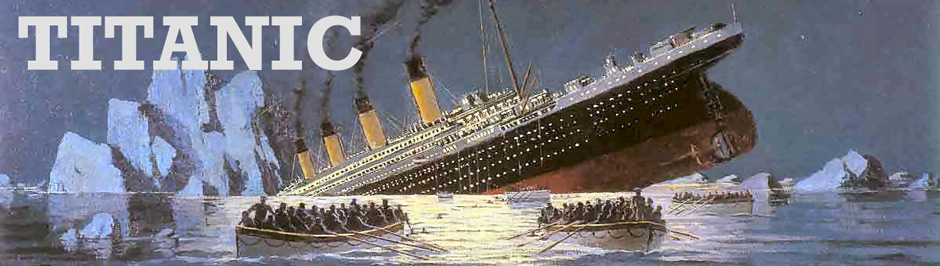

On April 14, 1912, the RMS Titanic hit an iceberg and sank. Of the 2223 aboard, only 706 were rescued. This notebook analyses the survival statistics to predict the likelihood of certain demographics surviving the disaster.
***

In [1]:
# (Optional) pip install pandas
# (Optional) !pip install seaborn
# (Optional) !pip install scikit-learn
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

warnings.simplefilter('ignore')

In [2]:
csv = pd.read_csv('dataset.csv')
dataset = pd.DataFrame(csv)

<div class="alert alert-block alert-info">
Before anything else, we perform basic visualisations to help intuit our data.
</div>

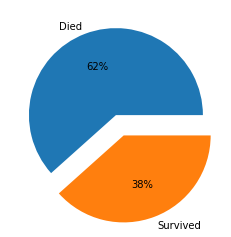

In [3]:
survival_data = dataset['Survived'].value_counts()
piechart_data = [survival_data[0], survival_data[1]]

label = ['Died', 'Survived']
explode = [0, 0.25]

plt.pie(piechart_data, labels = label, explode = explode, autopct='%.0f%%')
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Count'>

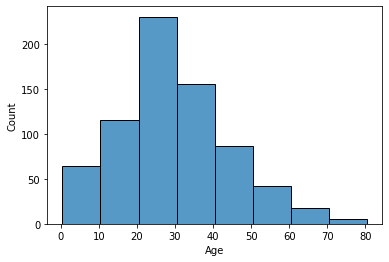

In [4]:
sns.histplot(data = dataset, x = 'Age', binwidth = 10)

<div class="alert alert-block alert-info">
We now have an idea of the age distribution of the passengers. We also know that the majority of them died. We can now move on to data cleaning. As our model cannot learn from irrelevant or absent data, we will begin inspecting fields for null values.
</div>

In [5]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<div class="alert alert-block alert-warning">
Unfortunately, there are two fields with significant missing data: 'Age', and 'Cabin'. However, we can use mean and mode imputation to generate new age and cabin values, respectively.
</div>

In [6]:
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mean()) # Mean imp.
dataset['Cabin'] = dataset['Cabin'].fillna(dataset['Cabin'].value_counts().index[0]) # Mode imp.
dataset[['Age', 'Cabin']].isnull().sum()

Age      0
Cabin    0
dtype: int64

In [7]:
dataset[['Age', 'Cabin']].head()

Age    Cabin
0  22.0  B96 B98
1  38.0      C85
2  26.0  B96 B98
3  35.0     C123
4  35.0  B96 B98

<div class="alert alert-block alert-danger">
After compensating for missing values, it seems that mode imputation is not a sensible approach for tackling the 'Cabin' field's null values. To avoid our model becoming affected by incomplete, irrelevant, or incorrect data, we will remove it (and other extraneous fields).
</div>

In [8]:
del dataset['PassengerId']
del dataset['Name']
del dataset['Ticket']
del dataset['Cabin']
del dataset['Embarked']
del dataset['Fare']

In [9]:
dataset.head()

Survived  Pclass     Sex   Age  SibSp  Parch
0         0       3    male  22.0      1      0
1         1       1  female  38.0      1      0
2         1       3  female  26.0      0      0
3         1       1  female  35.0      1      0
4         0       3    male  35.0      0      0

<div class="alert alert-block alert-info">
The next step involves converting our categorical variables into dummy variables for our model to understand. This includes: binning age values into child vs. adult binaries, and converting sex into male vs. female binaries.
</div>

In [10]:
dataset['IsAdult'] = pd.cut(dataset['Age'], [0, 17, 999], labels=[0, 1])
del dataset['Age']
dataset.head()

Survived  Pclass     Sex  SibSp  Parch IsAdult
0         0       3    male      1      0       1
1         1       1  female      1      0       1
2         1       3  female      0      0       1
3         1       1  female      1      0       1
4         0       3    male      0      0       1

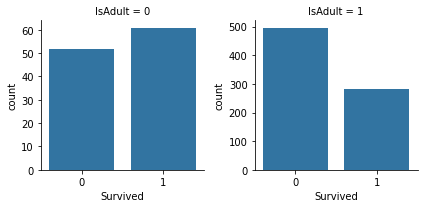

In [11]:
adult_eda = sns.FacetGrid(data = dataset, col = 'IsAdult', col_wrap = 2, sharey = False)
adult_eda.map(sns.countplot, 'Survived')

In [12]:
dataset = pd.get_dummies(dataset, columns=['Sex'], drop_first=True)
dataset.rename(columns = {'Sex_male':'IsMale'}, inplace = True)
dataset.head()

Survived  Pclass  SibSp  Parch IsAdult  IsMale
0         0       3      1      0       1       1
1         1       1      1      0       1       0
2         1       3      0      0       1       0
3         1       1      1      0       1       0
4         0       3      0      0       1       1

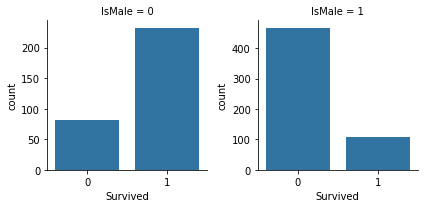

In [13]:
adult_eda = sns.FacetGrid(data = dataset, col = 'IsMale', col_wrap = 2, sharey = False)
adult_eda.map(sns.countplot, 'Survived')

In [14]:
dataset['IsFirstClass'] = pd.cut(dataset['Pclass'], [0, 1, 3], labels=[1, 0])
del dataset['Pclass']
dataset.head()

Survived  SibSp  Parch IsAdult  IsMale IsFirstClass
0         0      1      0       1       1            0
1         1      1      0       1       0            1
2         1      0      0       1       0            0
3         1      1      0       1       0            1
4         0      0      0       1       1            0

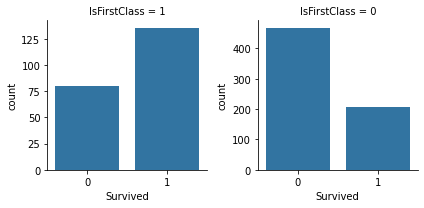

In [15]:
class_eda = sns.FacetGrid(data = dataset, col = 'IsFirstClass', col_wrap = 2, sharey = False)
class_eda.map(sns.countplot, 'Survived')

<div class="alert alert-block alert-info">
We have learned that the following demographics had the highest survival rates: children (marginal), females (significant), first-class (significant). Now, the final step before developing the model is splitting the data into testing and training sets.
</div>

In [16]:
dataset = dataset.values
sc = dataset[:, 0] # 'Survived' column
rc = dataset[:, 1:8] # Remaining columns
rc_train, rc_test, sc_train, sc_test = train_test_split(rc, sc, test_size = .90)

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_rc_train = scaler.fit_transform(rc_train)
scaled_rc_test = scaler.fit_transform(rc_test)

<div class="alert alert-block alert-info">
We now begin training a Logistic Regression model imported from the SciKit-Learn library.
</div>

In [18]:
model = LogisticRegression()
model.fit(scaled_rc_train, sc_train)

LogisticRegression()

In [19]:
sc_prediction = model.predict(scaled_rc_test)
accuracy_score = round(model.score(scaled_rc_test, sc_test)*100, 2)
print("Model accuracy: {0}%".format(accuracy_score))

Model accuracy: 79.05%


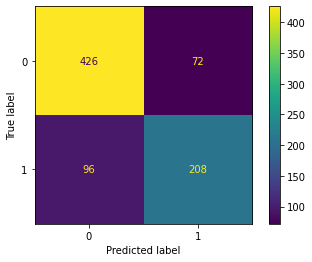

In [20]:
# (Optional) confusion_matrix(sc_test, sc_prediction)
cm = confusion_matrix(sc_test, sc_prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

<div class="alert alert-block alert-warning">
Our model accuracy is reasonably high. Our confusion matrix shows the model's performance via the following metrics: true-positives (bottom-right), true-negatives (top-left), false-positives (top-right), and false-negatives (bottom-left). We can improve model parameters using grid-searching.
</div>

In [21]:
tolerances = [.1, .01, .001]
iterations = [100, 150, 200]
parameter_grid = dict(tol=tolerances, max_iter=iterations)

In [22]:
gs = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=5)
scaled_rc = scaler.fit_transform(rc)
result = gs.fit(scaled_rc, sc)

best_score = round(result.best_score_*100, 2)
best_params = result.best_params_

print("Best accuracy: {0}%".format(best_score))
print("Best parameters:", best_params)

Best accuracy: 79.68%
Best parameters: {'max_iter': 100, 'tol': 0.1}


<div class="alert alert-block alert-success">
The model accuracy has increased after running a grid-search. We now have a functioning machine learning model capable of predicting passenger survival based on: class, number of siblings / spouses aboard, number of parents / children aboard, fare paid, age (i.e. adult vs. child status), and sex. It is tested below.
</div>

In [89]:
# REFERENCE: [SibSp, Parch, IsAdult, IsMale, IsFirstClass]
test01 = [0, 0, 0, 0, 1] # 1st-class child female (alone)
test02 = [0, 0, 1, 1 ,0] # Non-1st-class adult male (alone)
test03 = [0, 2, 0, 1, 1] # 1st-class child male (w. parents)

test_passengers = [test01, test02, test03]

In [94]:
index = 0

for passenger in test_passengers:
    print("Test #{0}: {1}".format(index+1, passenger))
    died_confidence = round(model.predict_proba(test_passengers)[index][0], 2) * 100
    survived_confidence = round(model.predict_proba(test_passengers)[index][1], 2) * 100
    
    if (prediction[index] == 1):
        print('------ RESULT: Survived! ({0}% confidence)\n'.format(survived_confidence))
    else:
        print('------ RESULT: Died. ({0}% confidence)\n'.format(died_confidence))
    
    index = index + 1

Test #1: [0, 0, 0, 0, 1]
------ RESULT: Survived! (91.0% confidence)

Test #2: [0, 0, 1, 1, 0]
------ RESULT: Died. (80.0% confidence)

Test #3: [0, 2, 0, 1, 1]
------ RESULT: Died. (60.0% confidence)

